This notebook tests several strategies implemented to select hyperparameters for tikhonet.

In [1]:
from astropy.io import fits as fits
from matplotlib import pyplot as plt
import matplotlib

matplotlib.rcParams['figure.figsize']=[12,8]

In [2]:
matplotlib.rcParams['figure.figsize']=[12,8]

In [3]:
## Set up the sys.path in order to be able to import our modules
import os
import sys
module_path = os.path.abspath(os.path.join('../python/'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
"""
Based on code written by alechat
"""

import os
import numpy as np
from subprocess import Popen, PIPE

def fits2npy(fits_file, idx_hdu):
    '''Read .fits containing the psf'''
    data = fits.getdata(fits_file, idx_hdu)
    nb_gal_row = data.shape[0]//96
    data_list = []
    idx_list = range(0, 10000)
    for i in idx_list:
        y = (96*i)%(nb_gal_row*96)
        x = i//nb_gal_row * 96
        data_list.append(data[x:x+96,y:y+96])
    return np.asarray(data_list)

def StampCollection2Mosaic(stamplist,gal_dim=96,nb_gal=10000):
    nb_gal_row = int(np.sqrt(nb_gal)) #nb galaxies per row
    mosaic=np.empty((nb_gal_row*gal_dim,nb_gal_row*gal_dim))
    for i in range(nb_gal):
        y = (gal_dim*i)%(nb_gal_row*gal_dim)
        x = i//nb_gal_row * gal_dim
        mosaic[x:x+gal_dim,y:y+gal_dim]=stamplist[i,:,:,0]
    return mosaic   

def compute_pixel_error(target_file, hdu_target, reconst_file, gal_dim=96, nb_gal=10000,xslice=slice(28,69,1),yslice=slice(28,69,1)):
    '''
    X: ground truth
    Y: estimated images
    '''
    nb_gal_row = int(np.sqrt(nb_gal)) #nb galaxies per row
    X = fits.getdata(target_file,hdu_target)
    Y = fits.getdata(reconst_file)
    DIFF=X-Y
    err = []
    for i in range(nb_gal):
        y = (gal_dim*i)%(nb_gal_row*gal_dim)
        x = i//nb_gal_row * gal_dim
        if gal_dim == 96:
            err.append((np.linalg.norm((DIFF[x:x+gal_dim,y:y+gal_dim])[xslice, 
                        yslice])**2)/(np.linalg.norm(X[x:x+gal_dim,y:y+gal_dim][xslice, yslice])**2))
        else:
            err.append((np.linalg.norm(DIFF[x:x+gal_dim,y:y+gal_dim])**2)/(np.linalg.norm(X[x:x+gal_dim,y:y+gal_dim])**2))
    return err

def generate_shape_txt(gal_file, psf_file, output_file, gal_dim=96, mosaic_size=100, save_weights='', weights_input=''):
    print('Computing ellipticity for file: %s'%(gal_file))
    print('Saving result in: %s'%(output_file))
    executable = '/data/shapelens_v2/shapelens-CEA-master/bin/get_shapes'
    if weights_input in '-o-i':
        cmd = '%s %s %s -p %s -g %d -s %d -T %s | tee %s'%(executable, weights_input, save_weights, psf_file, mosaic_size, gal_dim, gal_file, output_file)
    else:
        cmd = '%s -p %s -g %d -s %d -T %s | tee %s'%(executable, psf_file, mosaic_size, gal_dim, gal_file, output_file)
    print(cmd)
    cmd_file = 'get_shape.cmd'
    try:
        os.remove(cmd_file)
    except OSError:
        pass
    f = open(cmd_file, 'w')
    f.write('#! /bin/bash\n')
    f.write('source /home/fsureau/.bashrc\n')
    f.write(cmd)
    f.close()
    os.system('chmod 777 '+cmd_file)
    p = Popen('./'+cmd_file, stdout=PIPE, stderr=PIPE)
    stdout, stderr = p.communicate()
    return stdout, stderr

def get_target_shape(gal_file, output_file, idx=4):
    tmp_file = 'tmp'+str(np.random.randint(999))+'.fits'
    tmp_psf_file = 'tmp_psf'+str(np.random.randint(999))+'.fits'
    try:
        os.remove(tmp_file)
    except OSError:
        pass
    try:
        os.remove(tmp_psf_file)
    except OSError:
        pass
    images = fits.getdata(gal_file, idx)
    psfs = fits.getdata(gal_file, 3)
    fits.writeto(tmp_file, images)
    fits.writeto(tmp_psf_file, psfs)
    stdout, stderr = generate_shape_txt(tmp_file, tmp_psf_file, output_file)
    try:
        os.remove(tmp_file)
    except OSError:
        pass
    try:
        os.remove(tmp_psf_file)
    except OSError:
        pass
    return stdout, stderr

def get_ellipticity(file_name):
    ellip = []
    with open(file_name, 'r') as f:
        data = f.readlines()
    for l in data:
        ellip.append(np.array(l.split('\t')[3:5]).astype(np.float32))
    return np.asarray(ellip)

def compute_ellipticity_error(fileX, fileY, plot_hist=False, max_idx=10000):
    ellipX = get_ellipticity(fileX)[:max_idx]
    ellipY = get_ellipticity(fileY)[:max_idx]
    err = []
    for i in range(len(ellipY)):
        if (np.abs(ellipX[i]) > 1).any() or (np.abs(ellipY[i]) > 1).any():
            continue
        err.append(np.linalg.norm(ellipX[i]-ellipY[i]))
    if plot_hist:
        plt.figure()
        plt.hist(err, 100, range=(0,0.6))
        plt.show()
        print('Total samples = %d' %len(err))
    return err


def oracle_ellip(input_file, output_file, noise_std = 0):
    data = fits.getdata(input_file, 1)
    psf = fits.getdata(input_file, 3)
    if noise_std != 0:
        noise = np.random.normal(0, noise_std, size=data.shape)
        data += noise
    tmp_file = 'tmp'+str(np.random.randint(999))+'.fits'
    tmp_psf_file = 'tmp_psf'+str(np.random.randint(999))+'.fits'
    try:
        os.remove(tmp_file)
    except OSError:
        pass
    try:
        os.remove(tmp_psf_file)
    except OSError:
        pass
    fits.writeto(tmp_file, data)
    fits.writeto(tmp_psf_file, psf)
    generate_shape_txt(tmp_file, tmp_psf_file, output_file)
    try:
        os.remove(tmp_file)
    except OSError:
        pass
    try:
        os.remove(tmp_psf_file)
    except OSError:
        pass

(<matplotlib.axes._subplots.AxesSubplot at 0x7f959bae9e10>,
 <matplotlib.colorbar.Colorbar at 0x7f959bb3c860>)

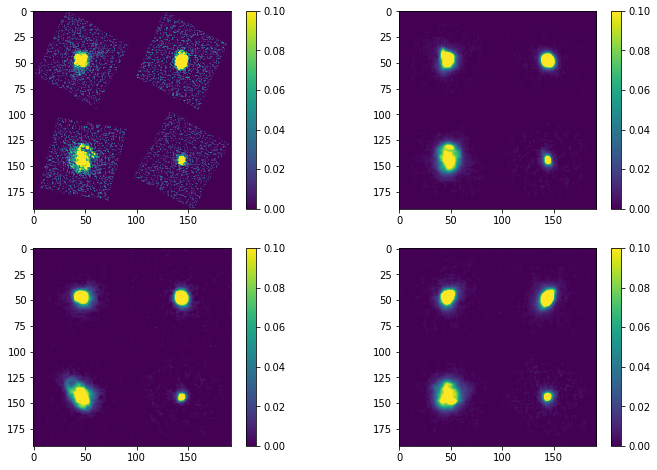

In [205]:
#Explore various results:
write_path="/data/DeepDeconv/benchmark/euclidpsf/"
testset_file = 'image-shfl-0-multihdu.fits'
target_name=testset_file.replace('.fits','-target_fwhm0p07.fits')
SNR=20
target=fits.getdata(write_path+'images/'+target_name)
unet4x4x4_name=write_path+"images/image-shfl-0-multihdu-UNet2D_FCS_sc3_layer4x4x4_relu_filt16_reshfl_SNR20to100_testSNR{0}.fits".format(SNR)
unet4x4x4=fits.getdata(unet4x4x4_name)
unet4x4x4_res_name=write_path+"images/image-shfl-0-multihdu-UNet2D_FCS_sc3_layer4x4x4_relu_filt16_resNet_reshfl_SNR20to100_testSNR{0}.fits".format(SNR)
unet4x4x4_res=fits.getdata(unet4x4x4_res_name)
deconvnet_name=write_path+"images/image-shfl-0-multihdu-DeconvNet2D_FCS_sc3_layer4x5x6_relu_growthRate12_reshfl_SNR20to100_testSNR{0}.fits".format(SNR)
deconvnet=fits.getdata(deconvnet_name)

plt.subplot(2,2,1),plt.imshow(target[0:192,0:192],vmin=0,vmax=0.1),plt.colorbar()
plt.subplot(2,2,2),plt.imshow(unet4x4x4[0:192,0:192],vmin=0,vmax=0.1),plt.colorbar()
plt.subplot(2,2,3),plt.imshow(unet4x4x4_res[0:192,0:192],vmin=0,vmax=0.1),plt.colorbar()
plt.subplot(2,2,4),plt.imshow(deconvnet[0:192,0:192],vmin=0,vmax=0.1),plt.colorbar()


In [206]:
from DeepDeconv.utils.conv_utils import recenter_psf,tf_dirac,tf_lap
from DeepDeconv.utils.batch_utils import format_dataset
from DeepDeconv.utils.data_utils import add_noise

SNR_SIMU=10

np.random.seed(19800607)

data_path='/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/'
#ref=(slice(96,192),slice(96,192)) #for centering
ref=(slice(96,192),slice(0,96)) #for spiral
train_im,train_tar,train_psf=format_dataset(data_path+testset_file,noiseless_img_hdu=0,
                   targets_hdu=2, psf_hdu=1, idx_list=np.arange(400),
                   image_dim=96,
                   image_per_row=100)
noisy_im,SNR_list,sigma_list=add_noise(train_im,SNR=SNR_SIMU)


## Estimate noise levels

In [527]:
import pywt
import scipy.stats


def mad_est_white_noise(noisy_im,wavelet_name='db3'):
    _,det = pywt.dwt2(noisy_im, wavelet_name)
    wavelet = pywt.Wavelet(wavelet_name)
    dec_len=wavelet.dec_len
    shift=dec_len//2
    cst=1.0/scipy.stats.norm.ppf(0.75, loc=0, scale=1)
    med=np.median(det[2][shift:-shift,shift:-shift])
    return cst*np.median(np.abs(det[2][shift:-shift,shift:-shift]-med))

def noise_level_est(set_im,wavelet_name='db3'):
    return np.array([mad_est_white_noise(im,wavelet_name=wavelet_name) for im in set_im])



EST= 1.0002598442123163


(<Figure size 864x576 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x7f95cb4de668>)

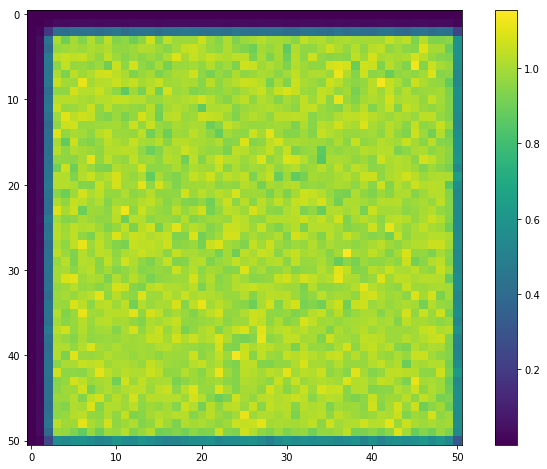

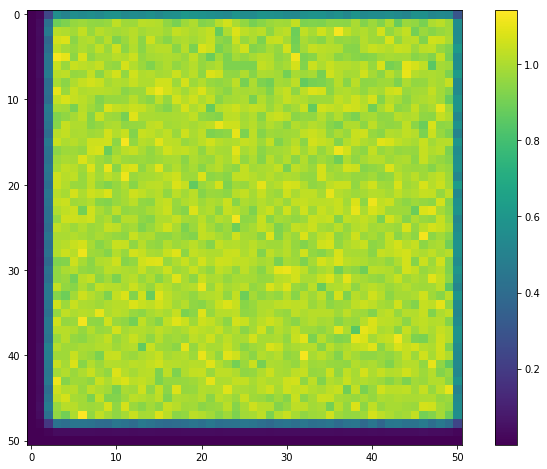

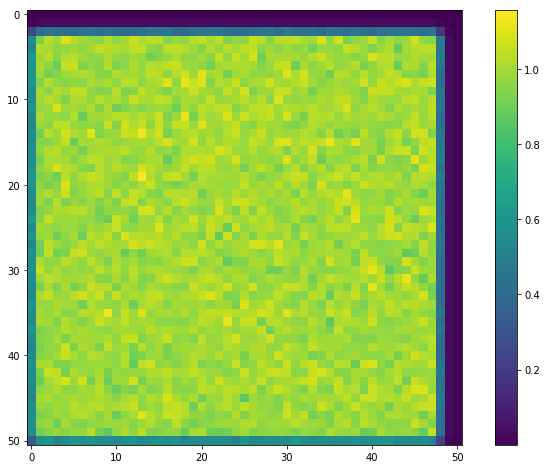

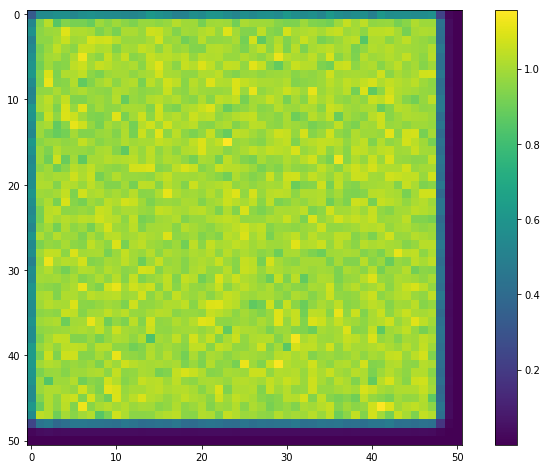

In [523]:
#'sym', 'coif', 'bior'
wave_name='db4'
for k in range(1000):
    ca,a=pywt.dwt2(np.random.normal(0,1,size=(96,96)),wave_name,mode='zero')
    wavelet = pywt.Wavelet(wave_name)
    shift=wavelet.dec_len//2
    if k==0:
        c2=np.zeros_like(ca)
        a2_0=np.zeros_like(ca)
        a2_1=np.zeros_like(ca)
        a2_2=np.zeros_like(ca)
    c2+=ca*ca
    a2_0+=a[0]*a[0]
    a2_1+=a[1]*a[1]
    a2_2+=a[2]*a[2]
print("EST=",np.mean(a2_2[shift:-shift,shift:-shift])/1000)
plt.figure(),plt.imshow(c2/1000),plt.colorbar()
plt.figure(),plt.imshow(a2_0/1000),plt.colorbar()
plt.figure(),plt.imshow(a2_1/1000),plt.colorbar()
plt.figure(),plt.imshow(a2_2/1000),plt.colorbar()

In [528]:
sigma_est=noise_level_est(noisy_im,wavelet_name='db4')

LinregressResult(slope=0.9988053956744686, intercept=-0.000357127119383599, rvalue=0.9983455117428209, pvalue=0.0, stderr=0.002883537529685612)


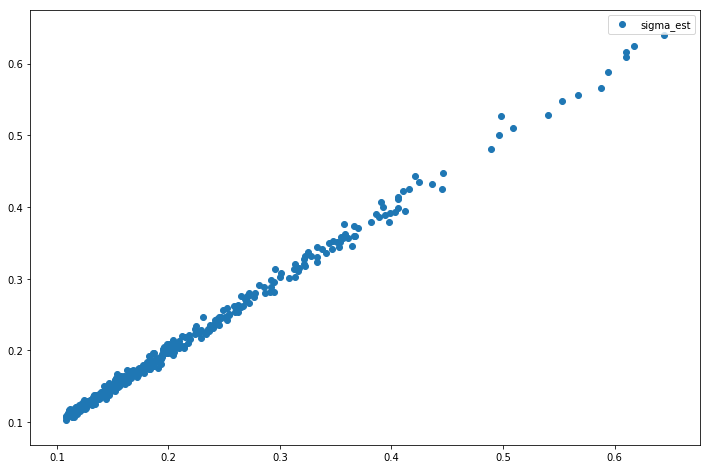

In [529]:
import scipy.stats
plt.scatter(sigma_list,sigma_est,label="sigma_est")
plt.legend()
print(scipy.stats.linregress(sigma_list,sigma_est))


## Generate regularization kernels

In [288]:
dirac_tf,dirac_ker=tf_dirac(2,(96,96),is_real=False)
lap_tf,lap_ker=tf_lap(2,(96,96),is_real=False)

## Perform Deconvolution with hyperparameter selection

In [289]:
import timeit
from DeepDeconv.utils.deconv_utils_FCS import tikhonov_hyp


tic = timeit.default_timer()
deconv_img_proj_sure,hyp_par_proj_sure=tikhonov_hyp(noisy_im,train_psf,dirac_tf,sigma_list**2,risktype="SureProj",tol=1e-12)
deconv_img_proj_sure_est,hyp_par_proj_sure_est=tikhonov_hyp(noisy_im,train_psf,dirac_tf,sigma_est**2,risktype="SureProj",tol=1e-12)
toc = timeit.default_timer()
print("TIKHONOV PROJ SURE MIN=",toc-tic)
tic = timeit.default_timer()
deconv_img_pred_sure,hyp_par_pred_sure=tikhonov_hyp(noisy_im,train_psf,dirac_tf,sigma_list**2,risktype="SurePred")
deconv_img_pred_sure_est,hyp_par_pred_sure_est=tikhonov_hyp(noisy_im,train_psf,dirac_tf,sigma_est**2,risktype="SurePred")
toc = timeit.default_timer()
print("TIKHONOV PRED SURE MIN=",toc-tic)
tic = timeit.default_timer()
deconv_img_gcv,hyp_par_gcv=tikhonov_hyp(noisy_im,train_psf,dirac_tf,sigma_list**2,risktype="GCV")
deconv_img_gcv_est,hyp_par_gcv_est=tikhonov_hyp(noisy_im,train_psf,dirac_tf,sigma_est**2,risktype="GCV")
toc = timeit.default_timer()
print("TIKHONOV GCV MIN=",toc-tic)
tic = timeit.default_timer()
deconv_img_per,hyp_par_per=tikhonov_hyp(noisy_im,train_psf,dirac_tf,sigma_list**2,risktype="Pereyra")
deconv_img_per_est,hyp_par_per_est=tikhonov_hyp(noisy_im,train_psf,dirac_tf,sigma_est**2,risktype="Pereyra")
toc = timeit.default_timer()
print("TIKHONOV PEREYRA  MIN=",toc-tic)



TIKHONOV PROJ SURE MIN= 13.374867315404117
TIKHONOV PRED SURE MIN= 10.189289070665836
TIKHONOV GCV MIN= 14.653179225511849
TIKHONOV PEREYRA  MIN= 12.71213467977941


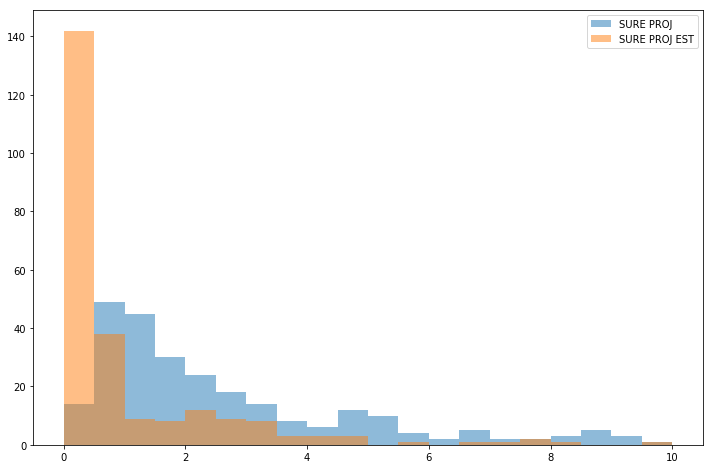

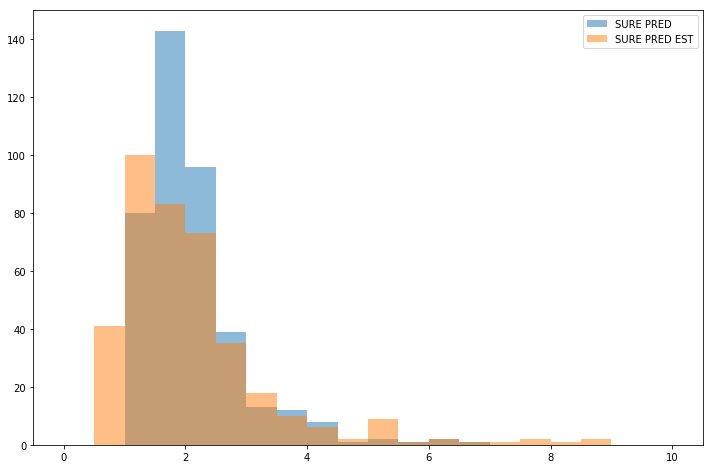

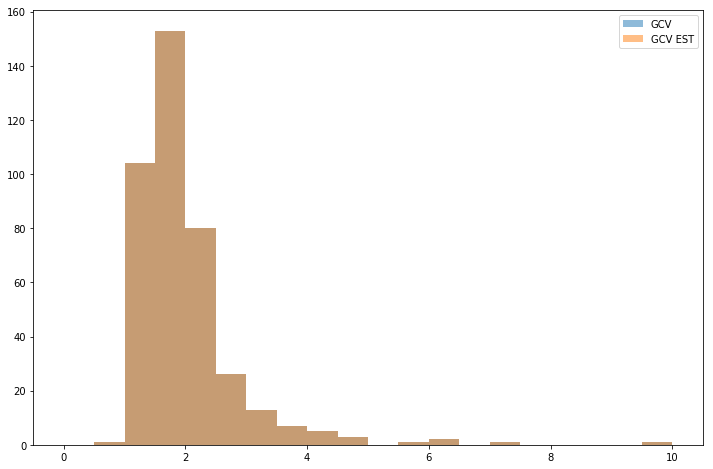

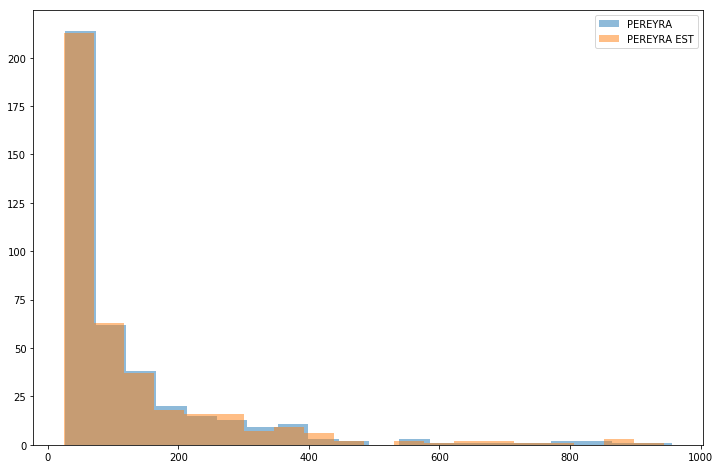

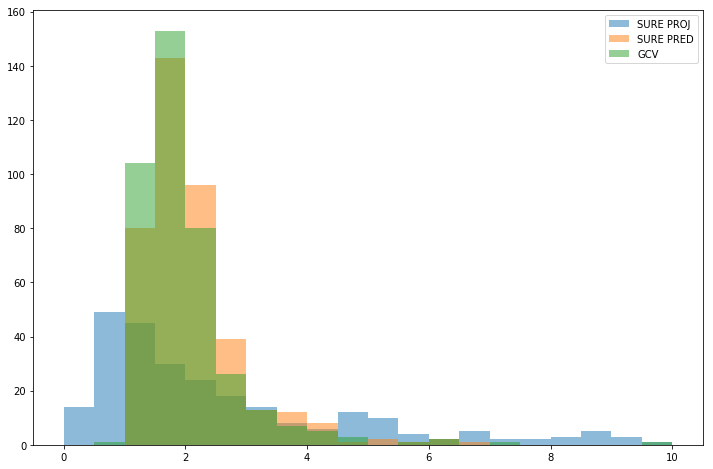

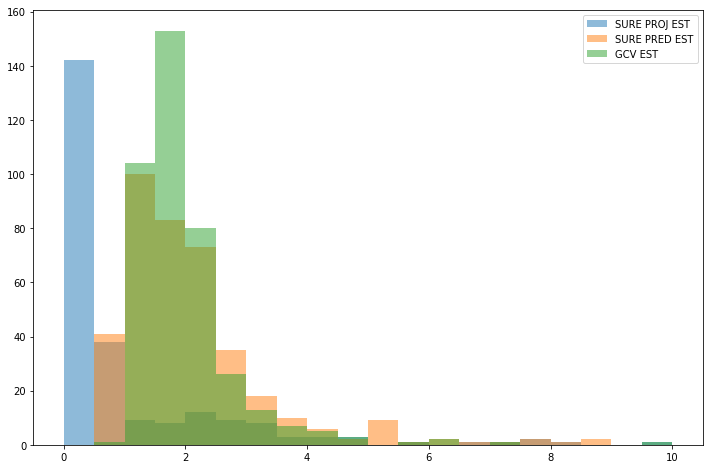

In [297]:
plt.figure()
_=plt.hist(hyp_par_proj_sure,bins=20,range=(0,10),alpha=0.5, label='SURE PROJ')
_=plt.hist(hyp_par_proj_sure_est,bins=20,range=(0,10),alpha=0.5, label='SURE PROJ EST')
plt.legend()

plt.figure()
_=plt.hist(hyp_par_pred_sure,bins=20,range=(0,10),alpha=0.5, label='SURE PRED')
_=plt.hist(hyp_par_pred_sure_est,bins=20,range=(0,10),alpha=0.5, label='SURE PRED EST')
plt.legend()

plt.figure()
_=plt.hist(hyp_par_gcv,bins=20,range=(0,10),alpha=0.5, label='GCV')
_=plt.hist(hyp_par_gcv_est,bins=20,range=(0,10),alpha=0.5, label='GCV EST')
plt.legend()

plt.figure()
_=plt.hist(hyp_par_per,bins=20,alpha=0.5, label='PEREYRA')
_=plt.hist(hyp_par_per_est,bins=20,alpha=0.5, label='PEREYRA EST')
plt.legend()

plt.figure()
_=plt.hist(hyp_par_proj_sure,bins=20,range=(0,10),alpha=0.5, label='SURE PROJ')
_=plt.hist(hyp_par_pred_sure,bins=20,range=(0,10),alpha=0.5, label='SURE PRED')
_=plt.hist(hyp_par_gcv,bins=20,range=(0,10),alpha=0.5, label='GCV')
plt.legend()

plt.figure()
_=plt.hist(hyp_par_proj_sure_est,bins=20,range=(0,10),alpha=0.5, label='SURE PROJ EST')
_=plt.hist(hyp_par_pred_sure_est,bins=20,range=(0,10),alpha=0.5, label='SURE PRED EST')
_=plt.hist(hyp_par_gcv_est,bins=20,range=(0,10),alpha=0.5, label='GCV EST')
plt.legend()


#### In short : important variations due to estimation of noise for SURE Proj. SURE Pred seems more robust.Pereyra gives extremely high values

## Check impact of tolerance to define orthogonal of null-space

In [298]:
import timeit
from DeepDeconv.utils.deconv_utils_FCS import tikhonov_hyp

deconv_img_proj_sure1,hyp_par_proj_sure1=tikhonov_hyp(noisy_im,train_psf,dirac_tf,sigma_list**2,risktype="SureProj",tol=1e-3)
deconv_img_proj_sure2,hyp_par_proj_sure2=tikhonov_hyp(noisy_im,train_psf,dirac_tf,sigma_list**2,risktype="SureProj",tol=1e-6)
deconv_img_proj_sure3,hyp_par_proj_sure3=tikhonov_hyp(noisy_im,train_psf,dirac_tf,sigma_list**2,risktype="SureProj",tol=1e-12)

In [299]:
hyp_par_proj_sure3[0],hyp_par_proj_sure1[0]

(0.8973672517018145, 0.8760791603260738)

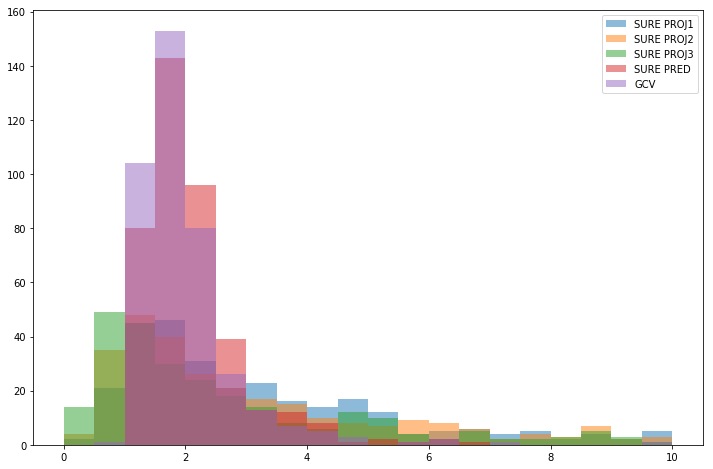

In [302]:
_=plt.hist(hyp_par_proj_sure1,bins=20,range=(0,10),alpha=0.5, label='SURE PROJ1')
_=plt.hist(hyp_par_proj_sure2,bins=20,range=(0,10),alpha=0.5, label='SURE PROJ2')
_=plt.hist(hyp_par_proj_sure3,bins=20,range=(0,10),alpha=0.5, label='SURE PROJ3')
_=plt.hist(hyp_par_pred_sure,bins=20,range=(0,10),alpha=0.5, label='SURE PRED')
_=plt.hist(hyp_par_gcv,bins=20,range=(0,10),alpha=0.5, label='GCV')
plt.legend()

#### There is a shift as well due to setting the support of the null space (or orthogonal). The smaller the support, the higher the parameter

## Check PROJ Sure cost function

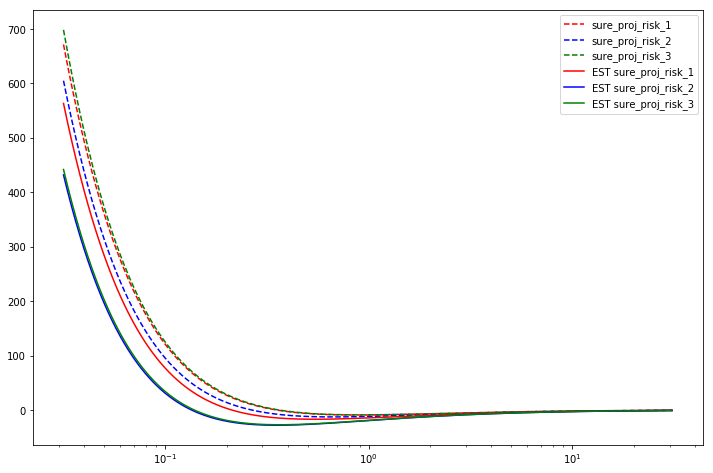

In [303]:
from skimage import restoration
import scipy
def proj_sure(h2,y2,x,reg2,sigma2):
    den=h2+x*reg2
    den2=den**2
    return np.sum(h2*y2/den2+2.0*(sigma2-y2)/den)

def proj_sure_list(h2,y2,xlist,reg2,sigma2):
    return [proj_sure(h2,y2,x,reg2,sigma2) for x in xlist]

check_hyper=10**np.arange(-1.5,1.5,0.01)

ind=0
psf_ctr=recenter_psf(train_psf[ind],np.array([-0.5,-0.5]))
trans_func = restoration.uft.ir2tf(psf_ctr, psf_ctr.shape, is_real=False)
trans_func_ps=np.abs(trans_func)**2
sigma2=sigma_list[ind]**2
sigma2_est=sigma_est[ind]**2



lst_nonz=np.where(trans_func_ps>1e-3)
h2_nonz=np.abs(trans_func[lst_nonz])**2 #This is |h_w|^2
l2_nonz=np.abs(lap_tf[lst_nonz])**2 #This is |l_w|^2 in case of laplacian
d2_nonz=np.abs(dirac_tf[lst_nonz])**2 #This is 1 (tikhonov:Dirac kernel)
y2_nonz=np.abs(restoration.uft.ufft2(noisy_im[ind])[lst_nonz])**2 #This is the FFT of noisy image

sure_proj_risk_1=proj_sure_list(h2_nonz.flatten(),y2_nonz.flatten(),check_hyper,d2_nonz.flatten(),sigma2)
sure_proj_risk_1_est=proj_sure_list(h2_nonz.flatten(),y2_nonz.flatten(),check_hyper,d2_nonz.flatten(),sigma2_est)


lst_nonz=np.where(trans_func_ps>1e-6)
h2_nonz=np.abs(trans_func[lst_nonz])**2 #This is |h_w|^2
l2_nonz=np.abs(lap_tf[lst_nonz])**2 #This is |l_w|^2 in case of laplacian
d2_nonz=np.abs(dirac_tf[lst_nonz])**2 #This is 1 (tikhonov:Dirac kernel)
y2_nonz=np.abs(restoration.uft.ufft2(noisy_im[ind])[lst_nonz])**2 #This is the FFT of noisy image

sure_proj_risk_2=proj_sure_list(h2_nonz.flatten(),y2_nonz.flatten(),check_hyper,d2_nonz.flatten(),sigma2)
sure_proj_risk_2_est=proj_sure_list(h2_nonz.flatten(),y2_nonz.flatten(),check_hyper,d2_nonz.flatten(),sigma2_est)



lst_nonz=np.where(trans_func_ps>1e-12)
h2_nonz=np.abs(trans_func[lst_nonz])**2 #This is |h_w|^2
l2_nonz=np.abs(lap_tf[lst_nonz])**2 #This is |l_w|^2 in case of laplacian
d2_nonz=np.abs(dirac_tf[lst_nonz])**2 #This is 1 (tikhonov:Dirac kernel)
y2_nonz=np.abs(restoration.uft.ufft2(noisy_im[ind])[lst_nonz])**2 #This is the FFT of noisy image

sure_proj_risk_3=proj_sure_list(h2_nonz.flatten(),y2_nonz.flatten(),check_hyper,d2_nonz.flatten(),sigma2)
sure_proj_risk_3_est=proj_sure_list(h2_nonz.flatten(),y2_nonz.flatten(),check_hyper,d2_nonz.flatten(),sigma2_est)


plt.plot(check_hyper,sure_proj_risk_1,label="sure_proj_risk_1",color='r',linestyle='--')
plt.plot(check_hyper,sure_proj_risk_2,label="sure_proj_risk_2",color='b',linestyle='--')
plt.plot(check_hyper,sure_proj_risk_3,label="sure_proj_risk_3",color='g',linestyle='--')

plt.plot(check_hyper,sure_proj_risk_1_est,label="EST sure_proj_risk_1",color='r',linestyle='-')
plt.plot(check_hyper,sure_proj_risk_2_est,label="EST sure_proj_risk_2",color='b',linestyle='-')
plt.plot(check_hyper,sure_proj_risk_3_est,label="EST sure_proj_risk_3",color='g',linestyle='-')
plt.legend()
plt.xscale('log')

#### This illustrates that when estimating the noise, a shift of hyperparameter value is observed

## Gather Data

In [304]:
from DeepDeconv.utils.file_utils import stampCollection2Mosaic
im_tar=stampCollection2Mosaic(train_tar,image_dim=96,image_per_row=20)
im_proj_sure=stampCollection2Mosaic(deconv_img_proj_sure1,image_dim=96,image_per_row=20)
im_pred_sure=stampCollection2Mosaic(deconv_img_pred_sure,image_dim=96,image_per_row=20)
im_gcv=stampCollection2Mosaic(deconv_img_gcv,image_dim=96,image_per_row=20)
im_per=stampCollection2Mosaic(deconv_img_per,image_dim=96,image_per_row=20)




(<matplotlib.image.AxesImage at 0x7f95ce8b1e80>,
 <matplotlib.colorbar.Colorbar at 0x7f95cdc484a8>)

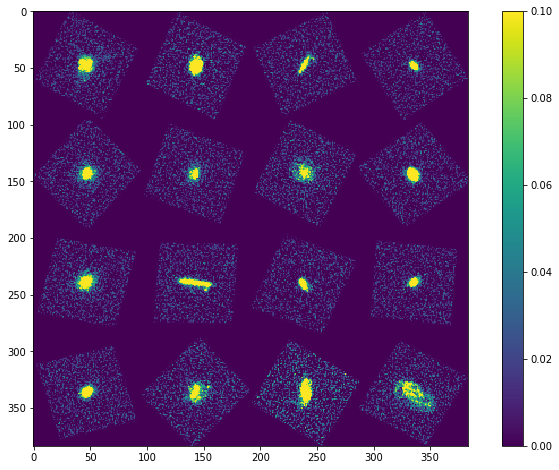

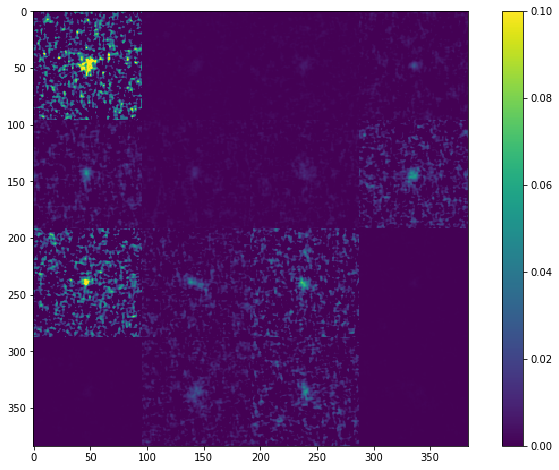

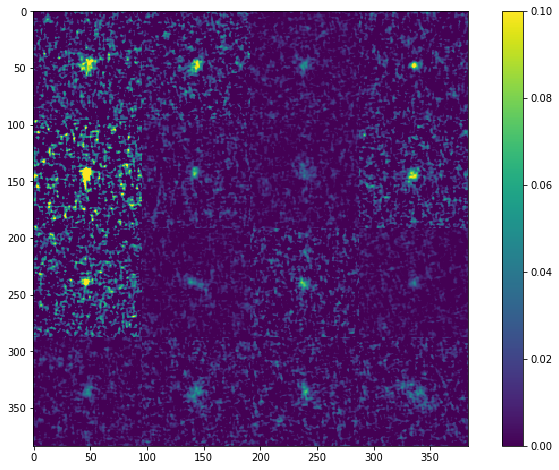

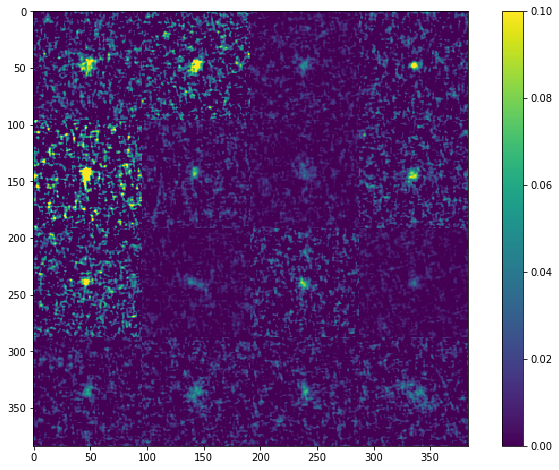

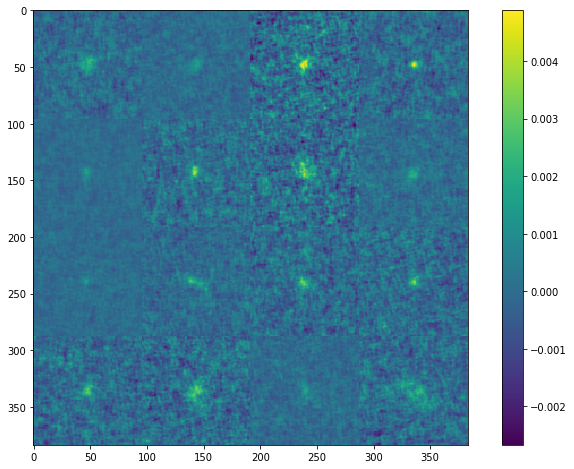

In [305]:
plt.figure()
plt.imshow(im_tar[0:384,0:384],vmin=0,vmax=0.1),plt.colorbar()
plt.figure()
plt.imshow(im_proj_sure[0:384,0:384],vmin=0,vmax=0.1),plt.colorbar()
plt.figure()
plt.imshow(im_pred_sure[0:384,0:384],vmin=0,vmax=0.1),plt.colorbar()
plt.figure()
plt.imshow(im_gcv[0:384,0:384],vmin=0,vmax=0.1),plt.colorbar()
plt.figure()
plt.imshow(im_per[0:384,0:384]),plt.colorbar()

## Investigate pereyra high values

### Functions to get hyperparam by hierarchical bayesian inference

In [405]:
from scipy.special import gamma
import math

def lambda_pereyra(noisy_im,trans_func,tau0,sigma,reg,nit=10,alpha=1,beta=1):
    tau_list=[tau0]
    tau_cur=tau0
    sigma2=sigma**2
    h2=np.abs(trans_func)**2 #This is |h_w|^2
    reg2=np.abs(reg)**2 #This is |l_w|^2 in case of laplacian
    y2=np.abs(restoration.uft.ufft2(noisy_im))**2 #This is the FFT of noisy image
    n_im=np.size(noisy_im)
    for kit in range(nit):
        deconv0=restoration.wiener(noisy_im,trans_func,tau_cur*sigma2,reg=reg, is_real=False,clip=False)
        deconv_lap=restoration.uft.uifft2(reg*restoration.uft.ufft2(deconv0))
        tau_cur=(n_im/2.0 + alpha - 1.0)/(0.5*np.linalg.norm(deconv_lap,ord='fro')**2+beta)
        tau_list.append(tau_cur)
    return np.array(tau_list)*sigma2
 
def lambda_pereyra_fourier(noisy_im,trans_func,tau0,sigma,reg,nit=10,alpha=1,beta=1):
    tau_list=[tau0]
    tau_cur=tau0
    sigma2=sigma**2
    h2=np.abs(trans_func)**2 #This is |h_w|^2
    reg2=np.abs(reg)**2 #This is |l_w|^2 in case of laplacian
    y2=np.abs(restoration.uft.ufft2(noisy_im))**2 #This is the FFT of noisy image
    n_im=np.size(noisy_im)
    num_f=h2*reg2*y2
    for kit in range(nit):
        deconvf2=num_f/(h2+tau_cur*sigma2*reg2)**2
        tau_cur=(n_im/2.0 + alpha - 1.0)/(0.5*np.sum(deconvf2)+beta)
        tau_list.append(tau_cur)
    return np.array(tau_list)*sigma2
#Note: gamma prior implies$ mean=\alpha/\beta$, and $var=\alpha/(\beta^2)$  
#tau_pereyra_wiener=lambda_pereyra(noisy_im,trans_func,1/sigma_list[0]**2,sigma_list[0],lap_tf,nit=20,alpha=1,beta=1)
#tau_pereyra_wiener_fourier=lambda_pereyra_fourier(noisy_im,trans_func,1,sigma_list[0],lap_tf,nit=20,alpha=1,beta=1)


def Pereyra_root_finding_fourier(noisy_im,trans_func,tau_list,sigma,reg,alpha=1,beta=1):
    sigma2=sigma**2
    h2=np.abs(trans_func)**2 #This is |h_w|^2
    reg2=np.abs(reg)**2 #This is |l_w|^2 in case of laplacian
    y2=np.abs(restoration.uft.ufft2(noisy_im))**2 #This is the FFT of noisy image
    n_im=np.size(noisy_im)
    num_f=h2*reg2*y2
    per_val=[]
    for tau_cur in tau_list:
        deconvf2=num_f/(h2+tau_cur*sigma2*reg2)**2
        per_val.append(tau_cur-(n_im/2.0 + alpha - 1.0)/(0.5*np.sum(deconvf2)+beta))
    return np.array(per_val)

def Pereyra_root_finding(noisy_im,trans_func,tau_list,sigma,reg,alpha=1,beta=1):
    sigma2=sigma**2
    h2=np.abs(trans_func)**2 #This is |h_w|^2
    reg2=np.abs(reg)**2 #This is |l_w|^2 in case of laplacian
    y2=np.abs(restoration.uft.ufft2(noisy_im))**2 #This is the FFT of noisy image
    n_im=np.size(noisy_im)
    per_val=[]
    num_val=[]
    den_val=[]
    for tau_cur in tau_list:
        deconv0=restoration.wiener(noisy_im,trans_func,tau_cur*sigma2,reg=reg, is_real=False,clip=False)
        deconv_lap=restoration.uft.uifft2(reg*restoration.uft.ufft2(deconv0))

        num_val.append((n_im/2.0 + alpha - 1.0))
        den_val.append((0.5*np.linalg.norm(deconv_lap,ord='fro')**2+beta))
        per_val.append(1.0-num_val[-1]/(tau_cur*den_val[-1]))
    return np.array(per_val),np.array(num_val),np.array(den_val)

def gamma_prior(tau_list,sigma,alpha=1,beta=1):

    prior_lam=[]
    for tau_cur in tau_list:
        prior_lam.append((-alpha*np.log(beta)+np.log(gamma(alpha))-(alpha-1)*np.log(tau_cur)+beta*tau_cur)*sigma2)
    return prior_lam

def cost_function(noisy_im,trans_func,tau_list,sigma,reg,alpha=1,beta=1):
    sigma2=sigma**2
    h2=(np.abs(trans_func)**2).flatten() #This is |h_w|^2
    reg2=(np.abs(reg)**2).flatten() #This is |l_w|^2 in case of laplacian
    y2=(np.abs(restoration.uft.ufft2(noisy_im))**2).flatten() #This is the FFT of noisy image
    n_im=np.size(noisy_im)
    num_f=h2*y2
    cost_val=[]
    like_val=[]
    prior_val=[]
    prior_lam=[]
    for tau_cur in tau_list:
        res2=y2*(1.0-h2/(h2+tau_cur*sigma2*reg2))**2
        deconvf2=h2*y2*reg2/(h2+tau_cur*sigma2*reg2)**2
        like_val.append(0.5*np.sum(res2))
        prior_val.append((0.5*tau_cur*np.sum(deconvf2)-n_im/2.0*math.log(tau_cur))*sigma2)
        gamma_prior=(-(alpha-1)*math.log(tau_cur)+beta*tau_cur)*sigma2
        prior_lam.append(gamma_prior)
        cost_val.append(prior_lam[-1]+prior_val[-1]+like_val[-1])
    return np.array(cost_val),np.array(like_val),np.array(prior_val),np.array(prior_lam)


def manual_deconv_l2(noisy_im,trans_func,trans_reg,hyp_param):
    hfstar=np.conj(trans_func)
    h2=np.abs(trans_func)**2
    d2=np.abs(trans_reg)**2
    filter_f=hfstar/(h2+hyp_param*d2)#/SNR_list[0]
    yf=restoration.uft.ufft2(noisy_im)
    sol=np.real(restoration.uft.uifft2(filter_f*yf))
    return sol

def manual_deconv_list_l2(noisy_im,trans_func,trans_reg,hyp_param_list):
    return np.array([manual_deconv_l2(noisy_im[k],trans_func[k],trans_reg,hyp_param_list[k]) for k in range(len(noisy_im))])

[6.60589590e-04 7.28373191e-03 1.68967033e-01 2.82409553e+00
 3.04307607e+00 3.04320347e+00 3.04320354e+00 3.04320354e+00
 3.04320354e+00 3.04320354e+00 3.04320354e+00 3.04320354e+00
 3.04320354e+00 3.04320354e+00 3.04320354e+00 3.04320354e+00
 3.04320354e+00 3.04320354e+00 3.04320354e+00 3.04320354e+00
 3.04320354e+00 3.04320354e+00 3.04320354e+00 3.04320354e+00
 3.04320354e+00 3.04320354e+00 3.04320354e+00 3.04320354e+00
 3.04320354e+00 3.04320354e+00 3.04320354e+00 3.04320354e+00
 3.04320354e+00 3.04320354e+00 3.04320354e+00 3.04320354e+00
 3.04320354e+00 3.04320354e+00 3.04320354e+00 3.04320354e+00
 3.04320354e+00 3.04320354e+00 3.04320354e+00 3.04320354e+00
 3.04320354e+00 3.04320354e+00 3.04320354e+00 3.04320354e+00
 3.04320354e+00 3.04320354e+00 3.04320354e+00 3.04320354e+00
 3.04320354e+00 3.04320354e+00 3.04320354e+00 3.04320354e+00
 3.04320354e+00 3.04320354e+00 3.04320354e+00 3.04320354e+00
 3.04320354e+00 3.04320354e+00 3.04320354e+00 3.04320354e+00
 3.04320354e+00 3.043203

(<matplotlib.image.AxesImage at 0x7f95cc80ccc0>,
 <matplotlib.colorbar.Colorbar at 0x7f95cbfa62e8>)

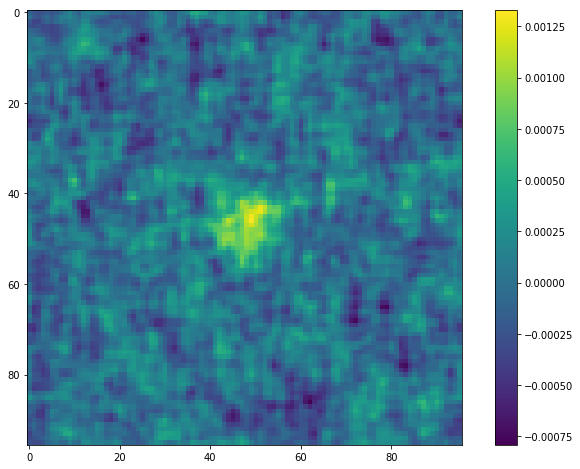

In [400]:
from skimage import restoration
ind=0
psf_ctr=recenter_psf(train_psf[ind],np.array([-0.5,-0.5]))
trans_func = restoration.uft.ir2tf(psf_ctr, psf_ctr.shape, is_real=False)
lambda_per2=lambda_pereyra(noisy_im[ind],trans_func,1,sigma_est[ind],dirac_tf,nit=100,alpha=1,beta=1)
print(lambda_per2/2*(sigma_est[ind])**2)

im_dec_l2_1=manual_deconv_l2(noisy_im[ind],trans_func,dirac_tf,lambda_per2[-1])
plt.imshow(im_dec_l2_1),plt.colorbar()

[2.06434247e-05 2.11220762e-04 2.87465723e-03 7.87035400e-02
 1.89683337e-01 1.90150636e-01 1.90151120e-01 1.90151120e-01
 1.90151120e-01 1.90151120e-01 1.90151120e-01 1.90151120e-01
 1.90151120e-01 1.90151120e-01 1.90151120e-01 1.90151120e-01
 1.90151120e-01 1.90151120e-01 1.90151120e-01 1.90151120e-01
 1.90151120e-01 1.90151120e-01 1.90151120e-01 1.90151120e-01
 1.90151120e-01 1.90151120e-01 1.90151120e-01 1.90151120e-01
 1.90151120e-01 1.90151120e-01 1.90151120e-01 1.90151120e-01
 1.90151120e-01 1.90151120e-01 1.90151120e-01 1.90151120e-01
 1.90151120e-01 1.90151120e-01 1.90151120e-01 1.90151120e-01
 1.90151120e-01 1.90151120e-01 1.90151120e-01 1.90151120e-01
 1.90151120e-01 1.90151120e-01 1.90151120e-01 1.90151120e-01
 1.90151120e-01 1.90151120e-01 1.90151120e-01 1.90151120e-01
 1.90151120e-01 1.90151120e-01 1.90151120e-01 1.90151120e-01
 1.90151120e-01 1.90151120e-01 1.90151120e-01 1.90151120e-01
 1.90151120e-01 1.90151120e-01 1.90151120e-01 1.90151120e-01
 1.90151120e-01 1.901511

(<matplotlib.image.AxesImage at 0x7f95cc784048>,
 <matplotlib.colorbar.Colorbar at 0x7f95cc774160>)

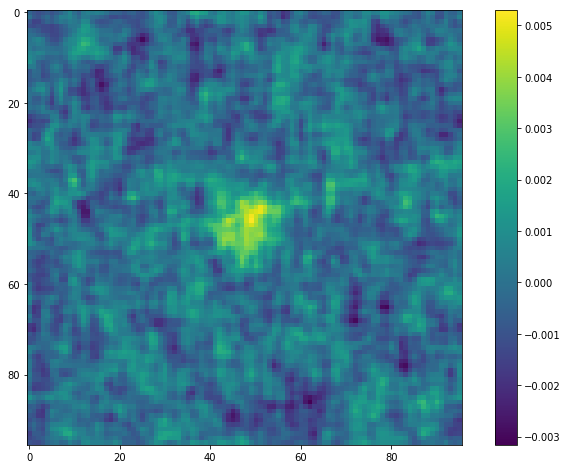

In [401]:
mu=0.5
lambda_per2_mu=lambda_pereyra(noisy_im[ind]*mu,trans_func,1,sigma_est[ind]*mu,dirac_tf,nit=100,alpha=1,beta=mu)
print(lambda_per2_mu*mu/2*(sigma_est[ind]*mu)**2)
im_dec_l2_mu=manual_deconv_l2(noisy_im[ind],trans_func,dirac_tf,lambda_per2_mu[-1])
plt.imshow(im_dec_l2_mu/mu),plt.colorbar()

8.494529702233438 8.494529702233438 7.940538634696475


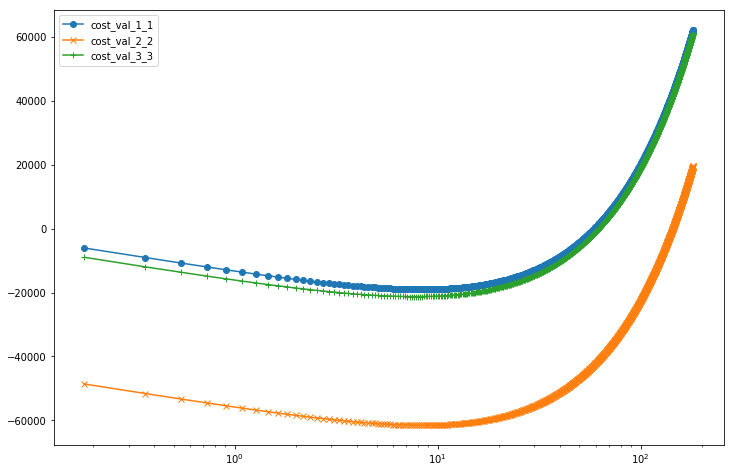

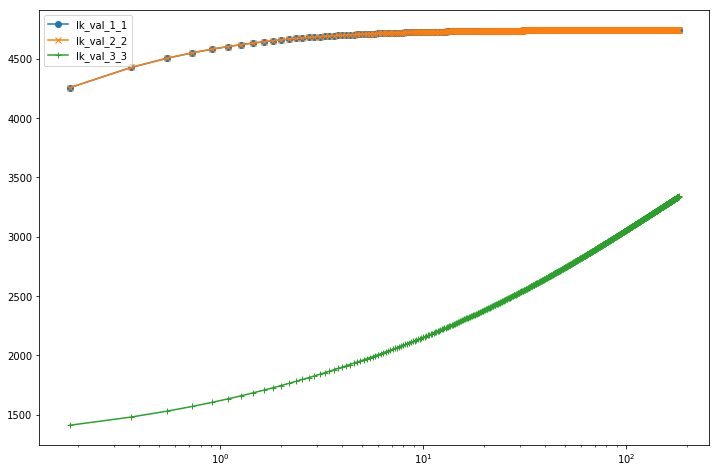

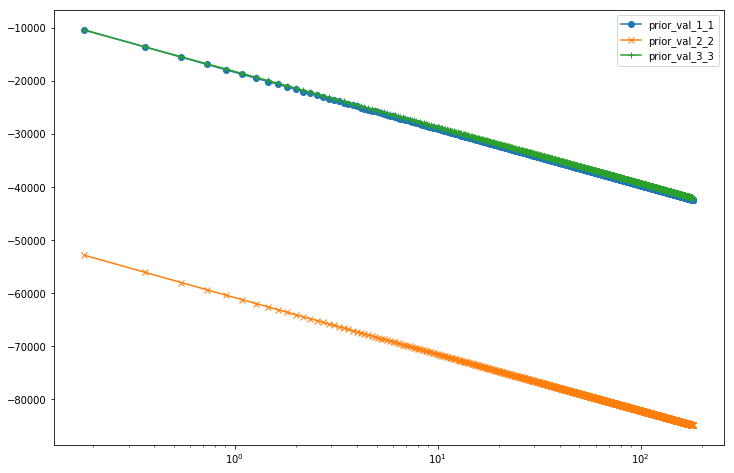

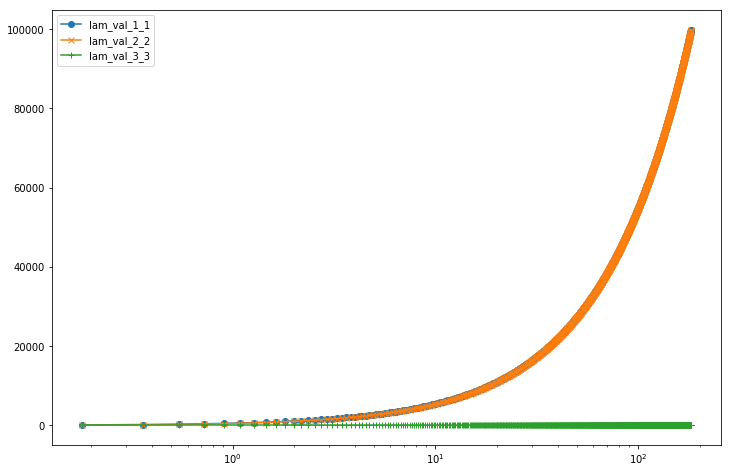

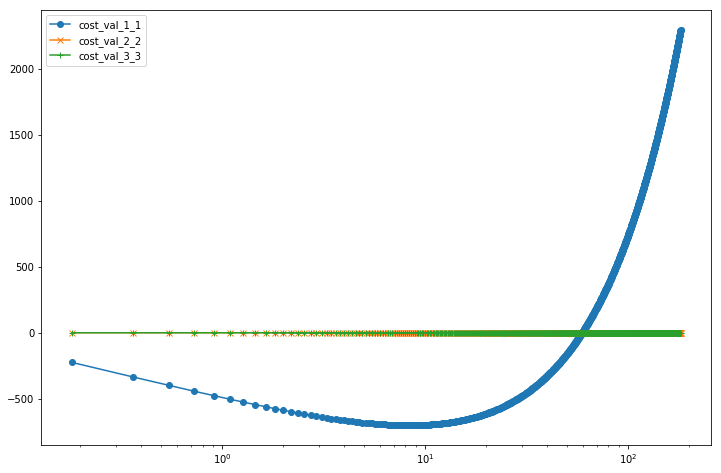

In [475]:
check_hyper=np.arange(10,10000,10)
mu=0.01
alpha_start=10
beta_start=10


#for mu in np.arange(1e-4,1e-2,1e-3):
check_hyper_mu=check_hyper/mu/mu
cost_val_1_1,lk_val_1_1,prior_val_1_1,lam_val_1_1=cost_function(noisy_im[ind],trans_func,check_hyper,
                                                sigma_list[ind],dirac_tf,alpha=alpha_start,beta=beta_start)
cost_val_2_2,lk_val_2_2,prior_val_2_2,lam_val_2_2=cost_function(noisy_im[ind]*mu,trans_func,check_hyper_mu,
                                                sigma_list[ind]*mu,dirac_tf,alpha=alpha_start,beta=beta_start*mu*mu)
cost_val_3_3,lk_val_3_3,prior_val_3_3,lam_val_3_3=cost_function(noisy_im[ind]*mu,trans_func,check_hyper,
                                                sigma_list[ind]*mu,dirac_tf,alpha=alpha_start,beta=beta_start)
#print(mu,check_hyper[np.argmin(cost_val_1_1)]*sigma2/2.0,check_hyper[np.argmin(cost_val_2_2)]*sigma2/2.0,check_hyper[np.argmin(cost_val_3_3)]*sigma2/2.0)



sigma2=sigma_list[ind]**2
sigma2_mu=(sigma_list[ind]*mu)**2


plt.figure()
plt.plot(check_hyper*(sigma_est[ind]**2)/2.0,cost_val_1_1/sigma2,label='cost_val_1_1',marker='o')
plt.plot(check_hyper*(sigma_est[ind]**2)/2.0,cost_val_2_2/sigma2_mu,label='cost_val_2_2',marker='x')
plt.plot(check_hyper*(sigma_est[ind]**2)/2.0,cost_val_3_3/sigma2_mu,label='cost_val_3_3',marker='+')
plt.xscale('log')
plt.legend()


plt.figure()
plt.plot(check_hyper*(sigma_est[ind]**2)/2.0,lk_val_1_1/sigma2,label='lk_val_1_1',marker='o')
plt.plot(check_hyper*(sigma_est[ind]**2)/2.0,lk_val_2_2/sigma2_mu,label='lk_val_2_2',marker='x')
plt.plot(check_hyper*(sigma_est[ind]**2)/2.0,lk_val_3_3/sigma2_mu,label='lk_val_3_3',marker='+')
plt.xscale('log')
plt.legend()


plt.figure()
plt.plot(check_hyper*(sigma_est[ind]**2)/2.0,prior_val_1_1/sigma2,label='prior_val_1_1',marker='o')
plt.plot(check_hyper*(sigma_est[ind]**2)/2.0,prior_val_2_2/sigma2_mu,label='prior_val_2_2',marker='x')
plt.plot(check_hyper*(sigma_est[ind]**2)/2.0,prior_val_3_3/sigma2_mu,label='prior_val_3_3',marker='+')
plt.xscale('log')
plt.legend()


plt.figure()
plt.plot(check_hyper*(sigma_est[ind]**2)/2.0,lam_val_1_1/sigma2,label='lam_val_1_1',marker='o')
plt.plot(check_hyper*(sigma_est[ind]**2)/2.0,lam_val_2_2/sigma2_mu,label='lam_val_2_2',marker='x')
plt.plot(check_hyper*(sigma_est[ind]**2)/2.0,lam_val_3_3/sigma2,label='lam_val_3_3',marker='+')
plt.xscale('log')
plt.legend()

#This is a mere shift on the rescaled version of mu
plt.figure()
plt.plot(check_hyper*(sigma_est[ind]**2)/2.0,cost_val_1_1,label='cost_val_1_1',marker='o')
plt.plot(check_hyper*(sigma_est[ind]**2)/2.0,cost_val_2_2,label='cost_val_2_2',marker='x')
plt.plot(check_hyper*(sigma_est[ind]**2)/2.0,cost_val_3_3,label='cost_val_3_3',marker='+')
plt.xscale('log')
plt.legend()


print(check_hyper[np.argmin(cost_val_1_1)]*sigma2/2.0,check_hyper[np.argmin(cost_val_2_2)]*sigma2/2.0,check_hyper[np.argmin(cost_val_3_3)]*sigma2/2.0)


In [419]:
print(96.0*96.0/2.0*np.log(10))

10610.312108516564


In [326]:
im_per_1=stampCollection2Mosaic(deconv_img_per_1,image_dim=96,image_per_row=20)
im_per_10=stampCollection2Mosaic(deconv_img_per_10,image_dim=96,image_per_row=20)

(<matplotlib.image.AxesImage at 0x7f95cde64470>,
 <matplotlib.colorbar.Colorbar at 0x7f95ce9a2a58>)

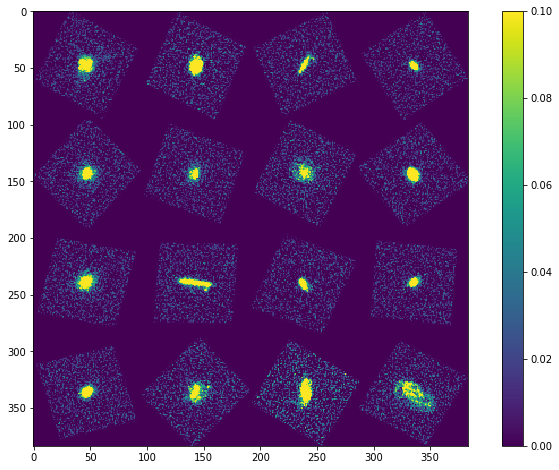

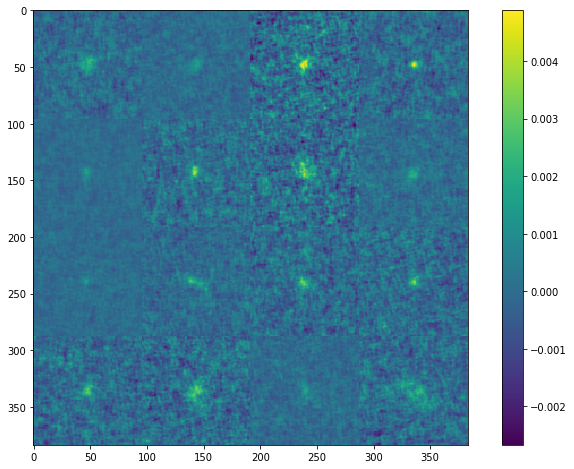

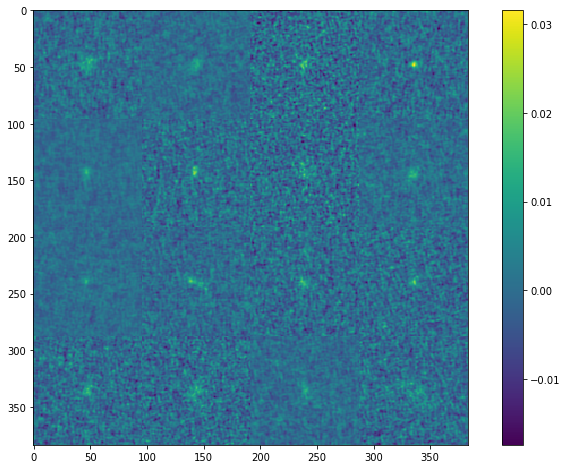

In [327]:
plt.figure()
plt.imshow(im_tar[0:384,0:384],vmin=0,vmax=0.1),plt.colorbar()
plt.figure()
plt.imshow(im_per_1[0:384,0:384]),plt.colorbar()
plt.figure()
plt.imshow(im_per_10[0:384,0:384]),plt.colorbar()




#### Show Gamma prior for hyperparameter

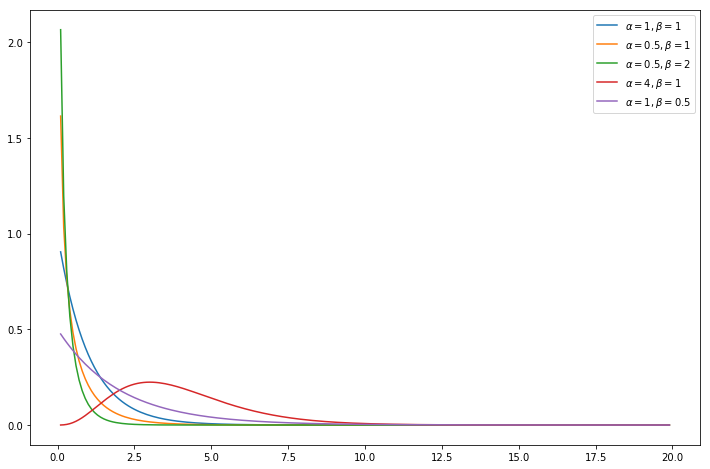

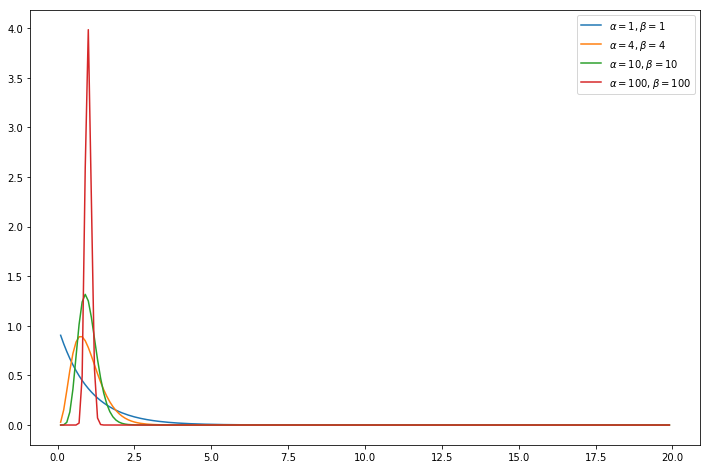

In [476]:
import scipy.stats
check_hyper=np.arange(1e-1,20,1e-1)
plt.plot(check_hyper,scipy.stats.gamma.pdf(check_hyper,1,0,1),label=r'$\alpha=1,\beta=1$')
plt.plot(check_hyper,scipy.stats.gamma.pdf(check_hyper,0.5,0,1),label=r'$\alpha=0.5,\beta=1$')
plt.plot(check_hyper,scipy.stats.gamma.pdf(check_hyper,0.5,0,1./2),label=r'$\alpha=0.5,\beta=2$')
plt.plot(check_hyper,scipy.stats.gamma.pdf(check_hyper,4,0,1),label=r'$\alpha=4,\beta=1$')
plt.plot(check_hyper,scipy.stats.gamma.pdf(check_hyper,1,0,2),label=r'$\alpha=1,\beta=0.5$')
plt.legend()
plt.figure()
plt.plot(check_hyper,scipy.stats.gamma.pdf(check_hyper,1,0,1),label=r'$\alpha=1,\beta=1$')
plt.plot(check_hyper,scipy.stats.gamma.pdf(check_hyper,4,0,0.25),label=r'$\alpha=4,\beta=4$')
plt.plot(check_hyper,scipy.stats.gamma.pdf(check_hyper,10,0,0.1),label=r'$\alpha=10,\beta=10$')
plt.plot(check_hyper,scipy.stats.gamma.pdf(check_hyper,100,0,0.01),label=r'$\alpha=100,\beta=100$')

plt.legend()




162.52617441615976 81.45604374765986 20.46083310542036
85.07154698827732


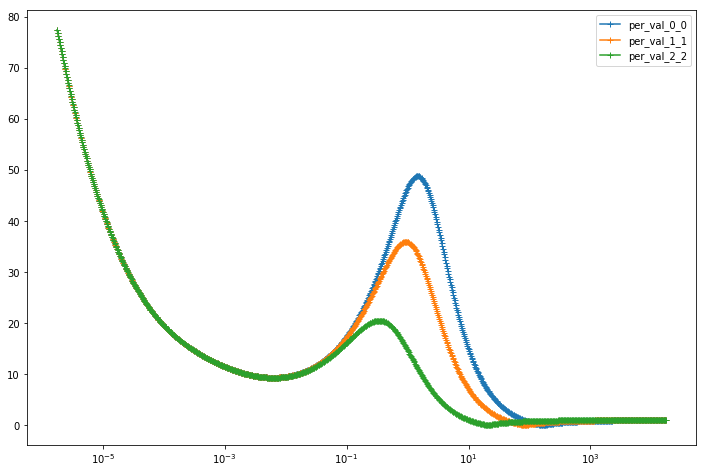

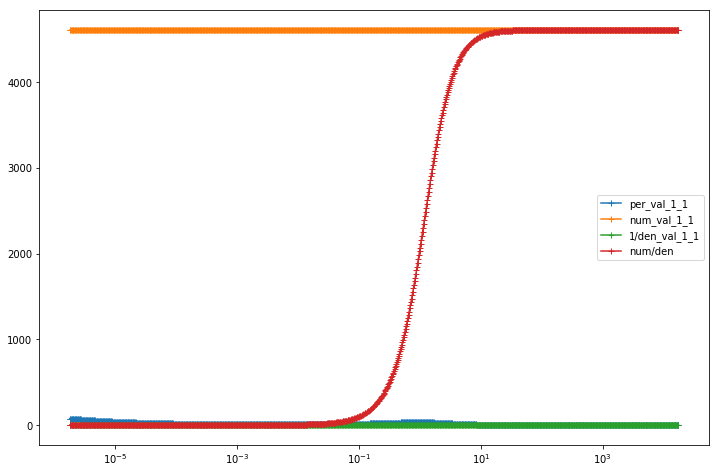

In [272]:
check_hyper=10**np.arange(-4.0,6.0,0.01)
psf_ctr=recenter_psf(train_psf[ind],np.array([-0.5,-0.5]))
trans_func = restoration.uft.ir2tf(psf_ctr, psf_ctr.shape, is_real=False)
trans_func_ps=np.abs(trans_func)**2


per_val_0_0,num_val_0_0,den_val_0_0=Pereyra_root_finding(noisy_im[ind],trans_func,check_hyper,sigma_list[ind],dirac_tf,alpha=1,beta=0.5)
per_val_1_1,num_val_1_1,den_val_1_1=Pereyra_root_finding(noisy_im[ind],trans_func,check_hyper,sigma_list[ind],dirac_tf,alpha=1,beta=1)
per_val_2_2,num_val_2_2,den_val_2_2=Pereyra_root_finding(noisy_im[ind],trans_func,check_hyper,sigma_list[ind],dirac_tf,alpha=4,beta=4)
plt.figure()
plt.plot(check_hyper*(sigma_est[ind]**2)/2.0,np.abs(per_val_0_0),label='per_val_0_0',marker='+')
plt.plot(check_hyper*(sigma_est[ind]**2)/2.0,np.abs(per_val_1_1),label='per_val_1_1',marker='+')
plt.plot(check_hyper*(sigma_est[ind]**2)/2.0,np.abs(per_val_2_2),label='per_val_2_2',marker='+')
plt.xscale('log')
plt.legend()
print(check_hyper[np.argmin(np.abs(per_val_0_0))]*(sigma_est[ind]**2)/2.0,
      check_hyper[np.argmin(np.abs(per_val_1_1))]*(sigma_est[ind]**2)/2.0,
      check_hyper[np.argmin(np.abs(per_val_2_2))]*(sigma_est[ind]**2)/2.0)

print(hyp_par_per[ind])
plt.figure()
plt.plot(check_hyper*(sigma_est[ind]**2)/2.0,np.abs(per_val_1_1),label='per_val_1_1',marker='+')
plt.plot(check_hyper*(sigma_est[ind]**2)/2.0,np.abs(num_val_1_1),label='num_val_1_1',marker='+')
plt.plot(check_hyper*(sigma_est[ind]**2)/2.0,np.abs(1./den_val_1_1),label='1/den_val_1_1',marker='+')
plt.plot(check_hyper*(sigma_est[ind]**2)/2.0,(num_val_1_1/den_val_1_1),label='num/den',marker='+')

plt.xscale('log')
plt.legend()




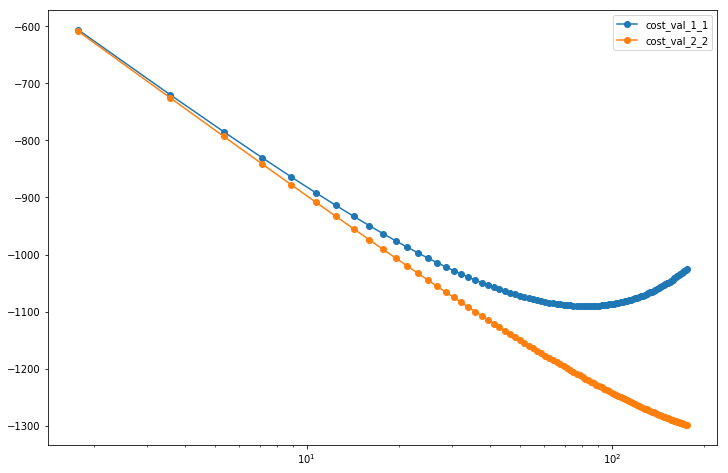

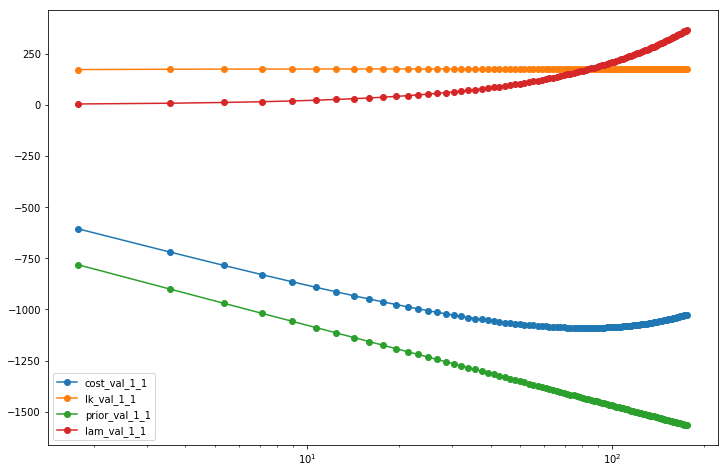

In [252]:
check_hyper=np.arange(100,10000,100)
cost_val_1_1,lk_val_1_1,prior_val_1_1,lam_val_1_1=cost_function(noisy_im[ind],trans_func,check_hyper,sigma_list[ind],dirac_tf,alpha=1,beta=1)
#cost_val_0_0,lk_val_0_0,prior_val_0_0,lam_val_0_0=cost_function(noisy_im[ind],trans_func,check_hyper,sigma_list[ind],dirac_tf,alpha=0,beta=0)
#cost_val_1_0,lk_val_0_0,prior_val_1_0,lam_val_1_0=cost_function(noisy_im[ind],trans_func,check_hyper,sigma_list[ind],dirac_tf,alpha=1,beta=0)
cost_val_2_2,lk_val_2_2,prior_val_2_2,lam_val_2_2=cost_function(noisy_im[ind],trans_func,check_hyper,sigma_list[ind],dirac_tf,alpha=0.25,beta=0.25)

#plt.plot(check_hyper*(sigma_est[ind]**2)/2.0,cost_val_0_0,label='cost_val_0_0',marker='o')
plt.plot(check_hyper*(sigma_est[ind]**2)/2.0,cost_val_1_1,label='cost_val_1_1',marker='o')
#plt.plot(check_hyper*(sigma_est[ind]**2)/2.0,cost_val_1_0,label='cost_val_1_0',marker='o')
plt.plot(check_hyper*(sigma_est[ind]**2)/2.0,cost_val_2_2,label='cost_val_2_2',marker='o')
plt.xscale('log')

plt.legend()

plt.figure()
plt.plot(check_hyper*(sigma_est[ind]**2)/2.0,cost_val_1_1,label='cost_val_1_1',marker='o')
plt.plot(check_hyper*(sigma_est[ind]**2)/2.0,lk_val_1_1,label='lk_val_1_1',marker='o')
plt.plot(check_hyper*(sigma_est[ind]**2)/2.0,prior_val_1_1,label='prior_val_1_1',marker='o')
plt.plot(check_hyper*(sigma_est[ind]**2)/2.0,lam_val_1_1,label='lam_val_1_1',marker='o')
plt.xscale('log')
plt.legend()











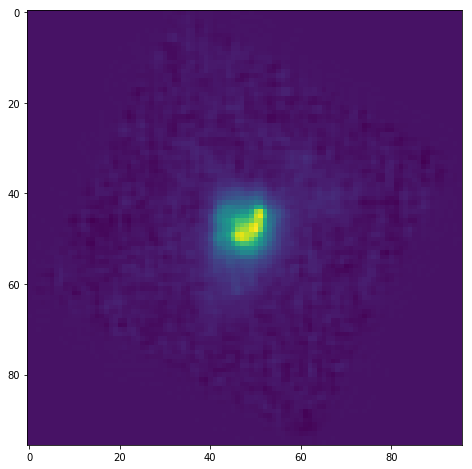

In [225]:
plt.imshow(train_im[ind])